In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp

# os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

In [15]:


df = pd.DataFrame( [[36.46,46.53],
                    [29.80,40.12],
                    [37.60,41.14],
                    [27.71,34.98],
                   
                   ],columns={"Brevis","Branchy"})
df.head()

,Branchy,Brevis
0,36.46,46.53
1,29.80,40.12
2,37.60,41.14
3,27.71,34.98


In [18]:
df.index

RangeIndex(start=0, stop=4, step=1)

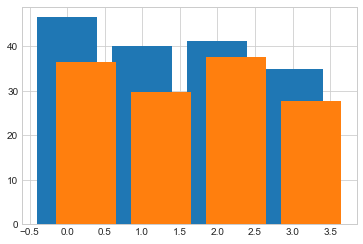

In [22]:
plt.bar(df.index,df["Brevis"])
plt.bar(df.index+0.25,df["Branchy"])
plt.show()

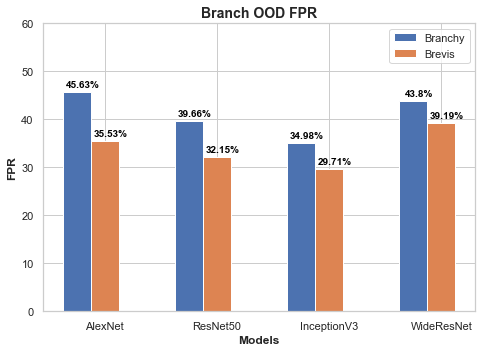

In [1]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import matplotlib.pyplot as plt
data = {"Branchy":[45.63,39.66,34.98,43.80],
        "Brevis":[35.53,32.15,29.71,39.19]}
model_labels=["AlexNet","ResNet50","InceptionV3","WideResNet"]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
spacing = 0.25
for i, (key,value) in enumerate(data.items()):
    for j, v in enumerate(value):
        # print(v)
        ax.text( j + (i*spacing) + .05, v + 1, str(v)+"%", horizontalalignment="center" ,color='black', fontweight='bold')
    ax.bar(X + i * spacing, data[key],  width = spacing, tick_label = model_labels, label=key)
ax.set_title("Branch OOD FPR",weight = "bold", size=14)
ax.set_ylabel("FPR", weight="bold")
ax.set_xlabel("Models", weight="bold")
# ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 60])
ax.legend(frameon=True,)


SyntaxError: invalid syntax (Temp/ipykernel_24516/2674659693.py, line 1)

<hr>
``ID / OOD EXAMPLES

In [26]:
# train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),1,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 10,reshuffle=True)

train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),1,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [29]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(50000, 3072).astype("float32") / 255
# test_images = test_images.reshape(10000, 3072).astype("float32") / 255
# print(train_images[0])
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255
# print("after")
# print(train_images[0])
# validation_size = 12000
# shuffle_size = 48000
# batch_size=32


# print(y_train)
K= 10 # number of classes

train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)


validation_size = 5000
shuffle_size = 22500
batch_size=32
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label,input_size=(227,227), channel_first = False):
            # Normalize images to have a mean of 0 and standard deviation of 1
            # image = tf.image.per_image_standardization(image)
            # image = tf.image.rgb_to_grayscale(image)
            # Resize images from 32x32 to 277x277
            # image = tf.reshape(image,(28,28,1))
            # image = tf.image.resize(image,input_size)
            # if channel_first:
            #     image = tf.transpose(image, [2, 0, 1])
            
            return image, label

train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))


# train_ds = (train_ds.map(augment_images))
# validation_ds = (validation_ds.map(augment_images))
# test_ds = (test_ds.map(augment_images))

# target = tf.data.Dataset.from_tensor_slices((train_labels))
# train_ds = tf.data.Dataset.zip((train_ds,target))

# v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
# validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

# t_target = tf.data.Dataset.from_tensor_slices((test_labels))
# test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))

trainSize 45000
testSize 10000


0


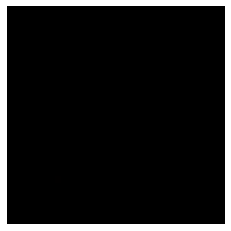

1


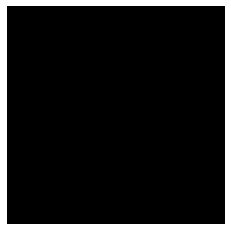

2


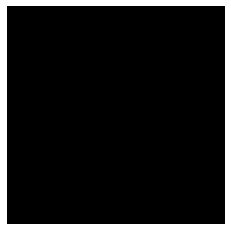

3


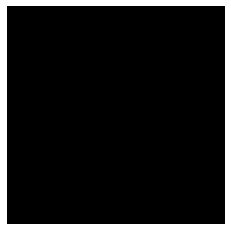

4


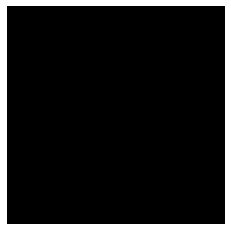

5


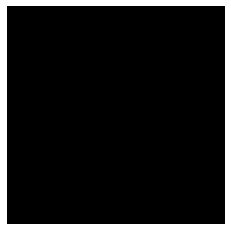

6


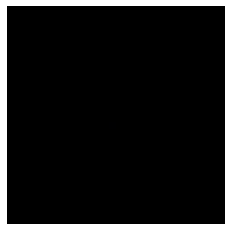

7


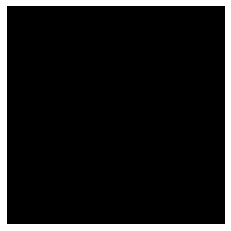

8


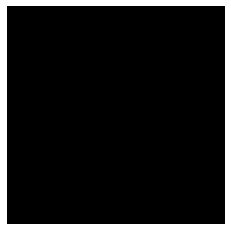

9


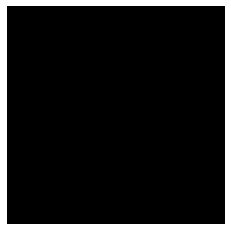

10


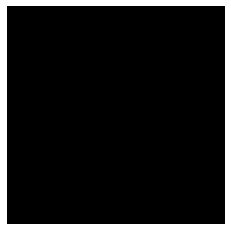

In [30]:
# plt.figure(figsize=(10, 10))
for i, (x,y) in enumerate(test_ds):
    if i > 10:
        break
    print(i)
    plt.imshow(x[0].numpy().astype("uint8"))
    # plt.title(y[0])
    plt.axis("off")
    plt.show()
    # print(x)

0


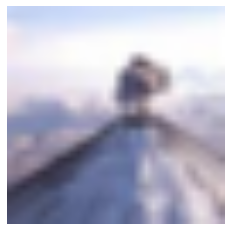

1


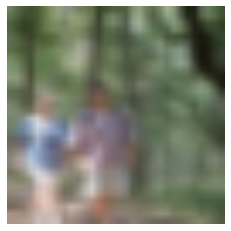

2


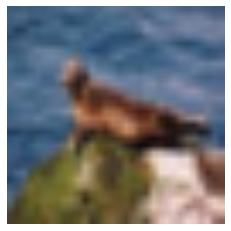

3


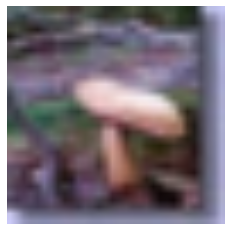

4


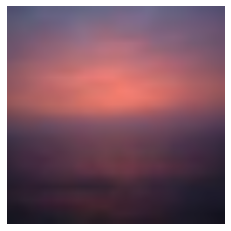

5


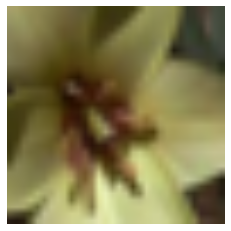

6


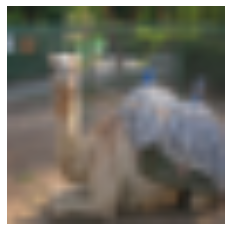

7


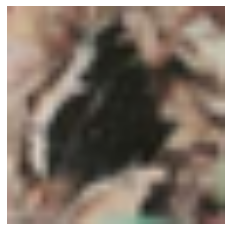

8


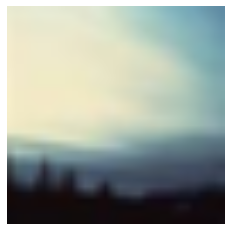

9


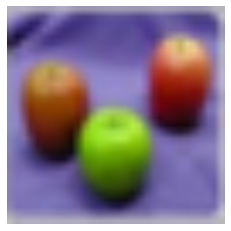

10


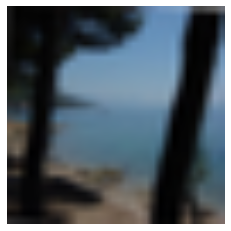

In [28]:
# plt.figure(figsize=(10, 10))
for i, (x,y) in enumerate(test_ds100):
    if i > 10:
        break
    print(i)
    plt.imshow(x[0].numpy().astype("uint8"))
    # plt.title(y[0])
    plt.axis("off")
    plt.show()
    # print(x)